# Experiment: maximum likelihood vs. variational Bayes

The goal of this notebook is to compare a mixture density network trained by maximum likelihood optimisation to an equivalent model trained using variational Bayesian inference.

## Example: inverted noisy oscillatory data

Import packages.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks as cb
tf.keras.backend.set_floatx("float64")
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from tools.preprocessing import Scaler

Generate example data.

In [2]:
def generate_data(N, noise_scale=0.2, seed=1):
    rng = np.random.default_rng(seed=seed)
    Y = rng.uniform(low=-1., high=1., size=N).T
    xi = rng.normal(size=N)
    noise = xi * noise_scale
    X = np.sin(10 * Y) + Y
    X += noise  # Additive Gaussian noise.
    X /= 3
    return X.reshape((-1, 1)), Y.reshape((-1, 1))

X, Y = generate_data(3200, seed=1)

Plot the data.

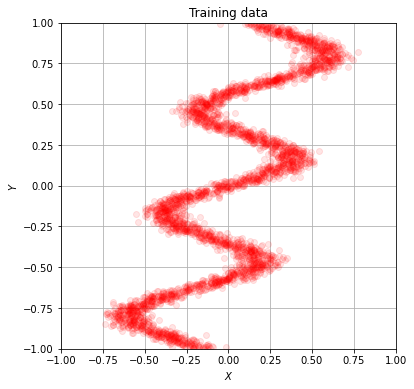

In [3]:
plt.figure(figsize=(6, 6))
plt.plot(X, Y, 'ro', alpha=0.1)
plt.xlabel(r'$X$'); plt.ylabel(r'$Y$')
plt.title('Training data')
plt.xlim(-1., 1.); plt.ylim(-1., 1.)
plt.grid(); plt.show()

## Maximum-likelihood model

In [4]:
# --- BUILD MODEL ---

# Data attributes
I_SIZE = X.shape[-1]
O_SIZE = Y.shape[-1]

# Model hyperparameters
N_C = 24

DENSITY_PARAMS_SIZE = tfpl.MixtureSameFamily.params_size(
    N_C, component_params_size=tfpl.MultivariateNormalTriL.params_size(O_SIZE))

ml_model = tf.keras.Sequential([
    tfkl.Dense(24, activation='relu'),
    tfkl.Dense(24, activation='relu'),
    tfkl.Dense(24, activation='relu'),
    tfkl.Dense(24, activation='relu'),
    tfkl.Dense(24, activation='relu'),
    tfkl.Dense(24, activation='relu'),
    tfkl.Dense(DENSITY_PARAMS_SIZE),
    tfpl.MixtureSameFamily(N_C, tfp.layers.MultivariateNormalTriL(O_SIZE))])

# --- STANDARDISE DATA ---

Xscaler = Scaler(X)
Yscaler = Scaler(Y)

X_ = Xscaler.standardise(X)
Y_ = Yscaler.standardise(Y)

# --- TRAIN MODEL ---

# Training configuration

def nll(y, Y): return -Y.log_prob(y)

LOSS = nll
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
EPOCHS = 2000
OPTIMISER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Model compilation and training
ml_model.compile(loss=LOSS, optimizer=OPTIMISER)

ml_History = ml_model.fit(X_, Y_,
                          epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_split=0.5,
                          verbose=0)

2022-08-05 00:04:37.678588: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-05 00:04:38.046535: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


See how training and test loss progresses during training.

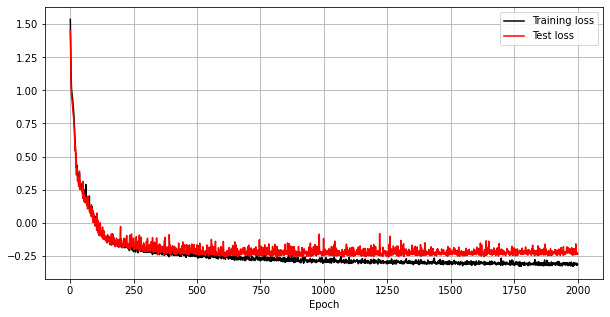

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), ml_History.history['loss'], 'k',
         label='Training loss')
plt.plot(range(1, EPOCHS + 1), ml_History.history['val_loss'], 'r',
         label='Test loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(); plt.show()

Plotting $p(Y|X)$.

In [6]:
n = 100
x = np.linspace(-0.75, 0.75, n).reshape((n, I_SIZE))
y = np.linspace(-1., 1., n).reshape((n, I_SIZE))
x_ = Xscaler.standardise(x)
y_ = Yscaler.standardise(y)
xx, yy = np.meshgrid(x, y)
lpyx = np.zeros((n, n))

for i in range(n):
    lpyx[i, :] = ml_model(x_[i:i + 1, ]).log_prob(y_)

pyx = Yscaler.invert_standardisation_prob(np.exp(lpyx))
lpyx = np.log(pyx)

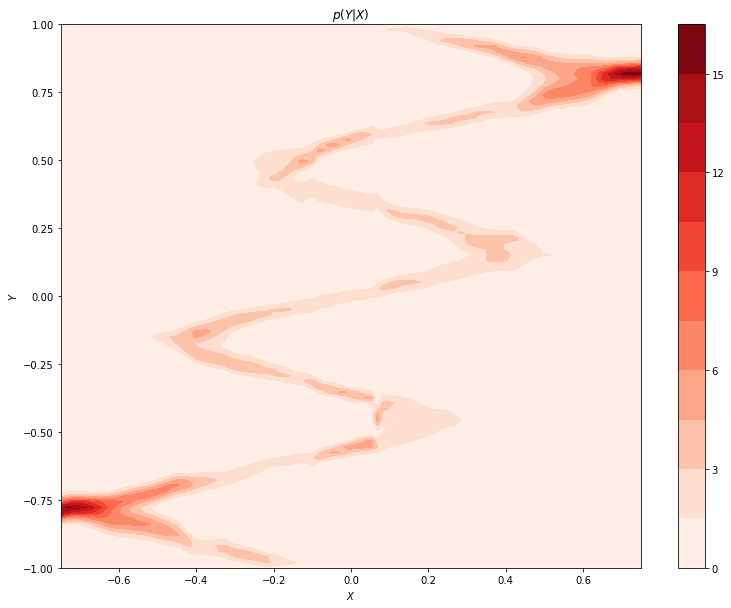

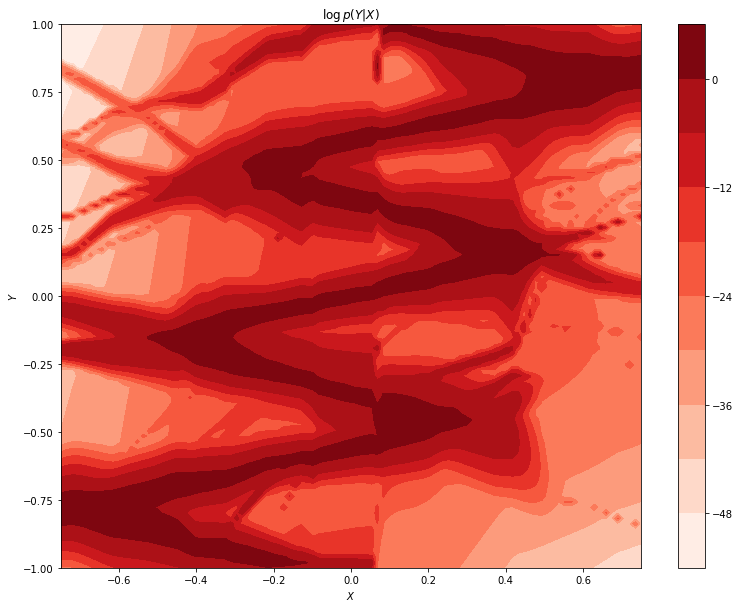

In [7]:
plt.figure(figsize=(13, 10))
plt.contourf(xx, yy, pyx.T, cmap='Reds', levels=10)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$p(Y|X)$')
plt.colorbar()
plt.show()

plt.figure(figsize=(13, 10))
plt.contourf(xx, yy, lpyx.T, cmap='Reds', levels=10)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$\log p(Y|X)$')
plt.colorbar()
plt.show()

Looking at $p(Y|X)$ for a particular value of $X$.

In [16]:
x_star = Xscaler.standardise(np.array((0.,)).reshape((1, I_SIZE)))
ys = np.linspace(-1., 1., 1000).reshape((1000, O_SIZE))
pygx_star = Yscaler.invert_standardisation_prob(
    np.exp(ml_model(x_star).log_prob(Yscaler.standardise(ys))))

plt.figure(figsize=(6, 4))
plt.plot(ys, pygx_star, 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$p(Y|X^*))$')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ys, pygx_star, 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$p(Y|X^*))$')
plt.yscale('log')
plt.show()

NameError: name 'ml_model' is not defined

## Variational Bayesian model

The cells below define priors and surrogate posteriors for 

In [9]:
def prior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  return lambda t: tfd.Independent(tfd.Normal(loc=tf.zeros(n, dtype=dtype), scale=1),
          reinterpreted_batch_ndims=1)

In [10]:
def posterior(kernel_size, bias_size, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfpl.VariableLayer(tfpl.IndependentNormal.params_size(n), dtype=dtype),
      tfpl.IndependentNormal(n)])

In [38]:
# --- BUILD MODEL ---

# Data attributes
I_SIZE = X.shape[-1]
O_SIZE = Y.shape[-1]

# Model hyperparameters
N_C = tf.cast(32, dtype=tf.int32)
N_N = tf.cast(64, dtype=tf.int32)
N_S = tf.cast(X.shape[0], dtype=tf.float64)

DENSITY_PARAMS_SIZE = tf.cast(tfpl.MixtureSameFamily.params_size(
    N_C, component_params_size=tfpl.MultivariateNormalTriL.params_size(O_SIZE)),
                              dtype=tf.int32)

kl_lib = tfd.kullback_leibler
df = (lambda q, p, ignore: kl_lib.kl_divergence(q, p) / N_S)

vi_model = tf.keras.Sequential([
    tfpl.DenseReparameterization(N_N, kernel_divergence_fn=df,
                                 bias_divergence_fn=df, activation='relu'),
    tfpl.DenseReparameterization(N_N, kernel_divergence_fn=df,
                                 bias_divergence_fn=df, activation='relu'),
    # tfpl.DenseReparameterization(N_N, kernel_divergence_fn=df,
    #                              bias_divergence_fn=df, activation='relu'),
    # tfpl.DenseReparameterization(N_N, kernel_divergence_fn=df,
    #                              bias_divergence_fn=df, activation='relu'),
    # tfpl.DenseReparameterization(N_N, kernel_divergence_fn=df,
    #                              bias_divergence_fn=df, activation='relu'),
    tfkl.Dense(N_N, activation='relu'),
    tfkl.Dense(N_N, activation='relu'),
    tfkl.Dense(N_N, activation='relu'),
    tfpl.DenseReparameterization(N_N, kernel_divergence_fn=df,
                                 bias_divergence_fn=df, activation='relu'),
    tfpl.DenseReparameterization(DENSITY_PARAMS_SIZE, kernel_divergence_fn=df,
                                 bias_divergence_fn=df),
    tfpl.MixtureSameFamily(N_C, tfp.layers.MultivariateNormalTriL(O_SIZE))])

# --- STANDARDISE DATA ---

Xscaler = Scaler(X)
Yscaler = Scaler(Y)

X_ = Xscaler.standardise(X)
Y_ = Yscaler.standardise(Y)

In [39]:
x_star = Xscaler.standardise(np.array((0.,)).reshape((1, I_SIZE)))  # !!!
ys = np.linspace(-1., 1., 1000).reshape((1000, O_SIZE))
ens = []
for i in range(100):
    pygx_star = Yscaler.invert_standardisation_prob(
        np.exp(vi_model(x_star).log_prob(Yscaler.standardise(ys))))
    ens.append(pygx_star)
ens = np.array(ens)

/home/s1511699/anaconda3/envs/ml/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  loc = add_variable_fn(
/home/s1511699/anaconda3/envs/ml/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  untransformed_scale = add_variable_fn(


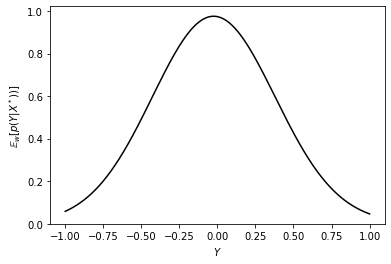

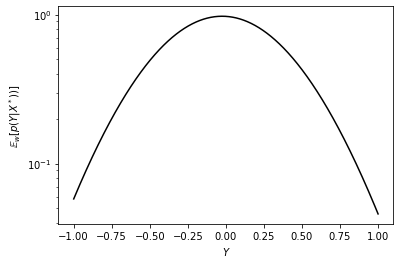

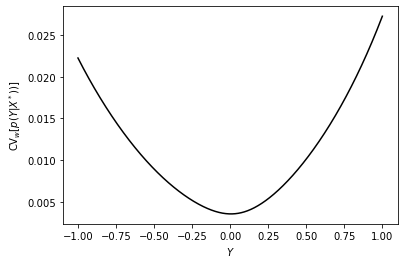

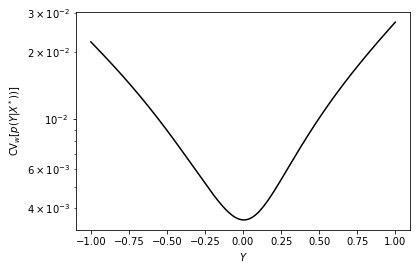

In [40]:
plt.figure(figsize=(6, 4))
plt.plot(ys, ens.mean(axis=0), 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$\mathbb{E}_w[p(Y|X^*))]$')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ys, ens.mean(axis=0), 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$\mathbb{E}_w[p(Y|X^*))]$')
plt.yscale('log')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ys, ens.std(axis=0) / ens.mean(axis=0), 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$\mathrm{CV}_w[p(Y|X^*))]$')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ys, ens.std(axis=0) / ens.mean(axis=0), 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$\mathrm{CV}_w[p(Y|X^*))]$')
plt.yscale('log')
plt.show()

In [53]:
# --- TRAIN MODEL ---

# Training configuration

def nll(y, Y): return -Y.log_prob(y)

LOSS = nll
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
EPOCHS = 500
OPTIMISER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Model compilation and training
vi_model.compile(loss=LOSS, optimizer=OPTIMISER)

vi_History = vi_model.fit(X_, Y_,
                       epochs=EPOCHS,
                       batch_size=BATCH_SIZE,
                       validation_split=0.5,
                       verbose=1)

Epoch 1/500
50/50 [==============================] - 2s 12ms/step - loss: 0.2867 - val_loss: 0.2903
Epoch 2/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2865 - val_loss: 0.2969
Epoch 3/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2806 - val_loss: 0.2889
Epoch 4/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2926 - val_loss: 0.2864
Epoch 5/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2699 - val_loss: 0.2958
Epoch 6/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2696 - val_loss: 0.2843
Epoch 7/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2600 - val_loss: 0.2798
Epoch 8/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2711 - val_loss: 0.2909
Epoch 9/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2607 - val_loss: 0.3107
Epoch 10/500
50/50 [==============================] - 0s 5ms/step - loss: 0.2793 - val_loss: 0.2736
Epoch 11

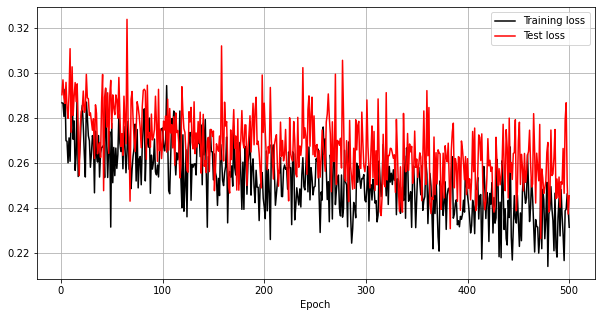

In [54]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), vi_History.history['loss'], 'k',
         label='Training loss')
plt.plot(range(1, EPOCHS + 1), vi_History.history['val_loss'], 'r',
         label='Test loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(); plt.show()

### Posterior mean estimates

In [55]:
n = 100
x = np.linspace(-0.75, 0.75, n).reshape((n, I_SIZE))
y = np.linspace(-1., 1., n).reshape((n, I_SIZE))
x_ = Xscaler.standardise(x)
y_ = Yscaler.standardise(y)
xx, yy = np.meshgrid(x, y)

ens_pyx = []
ens_lpyx = []
for j in range(1):
    lpyx = np.zeros((n, n))
    for i in range(n):
        lpyx[i, :] = vi_model(x_[i:i + 1, ]).log_prob(y_)
    pyx = Yscaler.invert_standardisation_prob(np.exp(lpyx))
    lpyx = np.log(pyx)
    ens_pyx.append(pyx)
    ens_lpyx.append(lpyx)

ens_pyx = np.array(ens_pyx)
ens_lpyx = np.array(ens_lpyx)

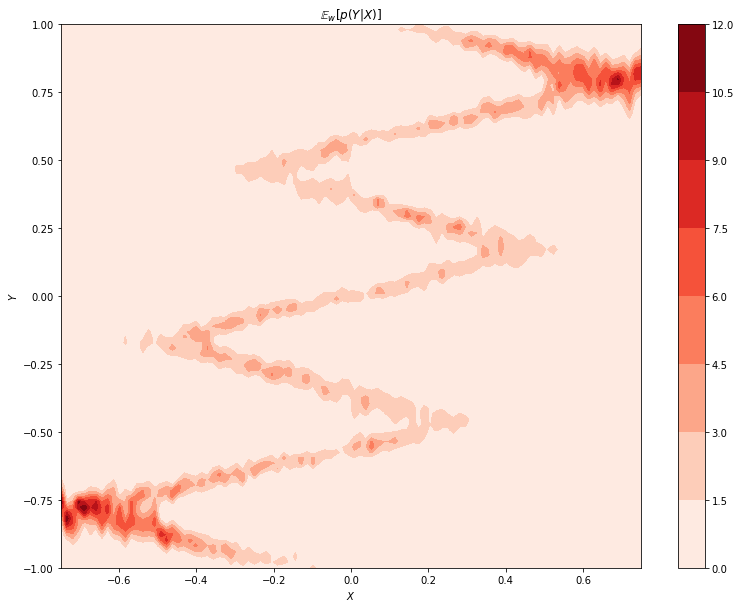

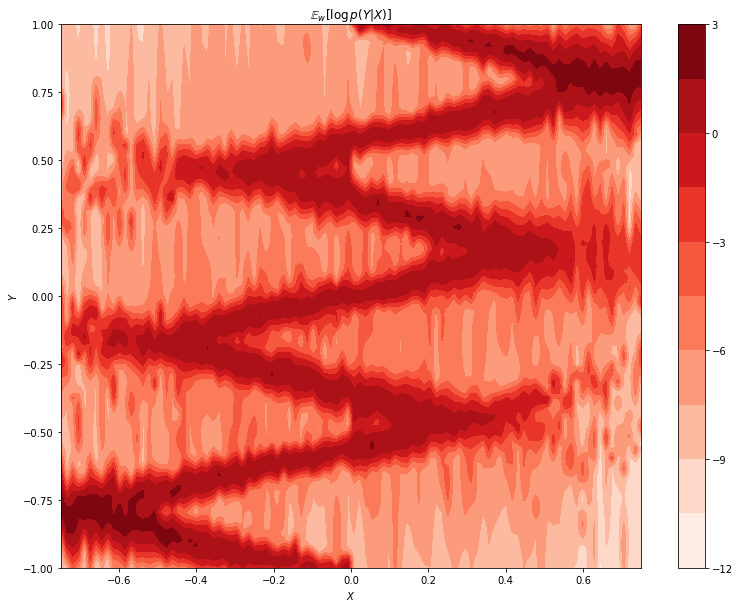

In [56]:
plt.figure(figsize=(13, 10))
plt.contourf(xx, yy, ens_pyx.mean(axis=0).T, cmap='Reds', levels=10)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$\mathbb{E}_w[p(Y|X)]$')
plt.colorbar()
plt.show()

plt.figure(figsize=(13, 10))
plt.contourf(xx, yy, ens_lpyx.mean(axis=0).T, cmap='Reds', levels=10)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(r'$\mathbb{E}_w[\log p(Y|X)]$')
plt.colorbar()
plt.show()

Looking at $p(Y|X)$ for a particular value of $X$.

In [57]:
x_star = Xscaler.standardise(np.array((0.,)).reshape((1, I_SIZE)))  # !!!
ys = np.linspace(-1., 1., 1000).reshape((1000, O_SIZE))
ens = []
for i in range(100):
    pygx_star = Yscaler.invert_standardisation_prob(
        np.exp(vi_model(x_star).log_prob(Yscaler.standardise(ys))))
    ens.append(pygx_star)
ens = np.array(ens)

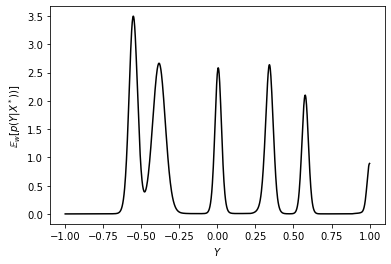

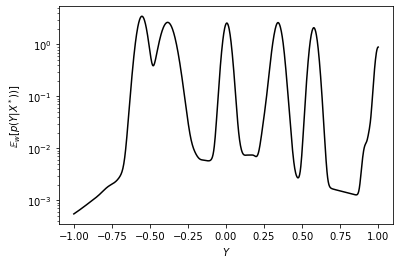

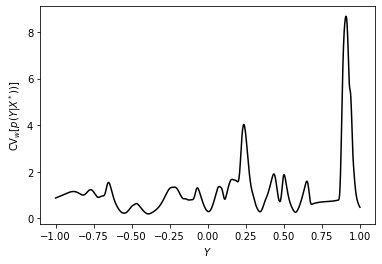

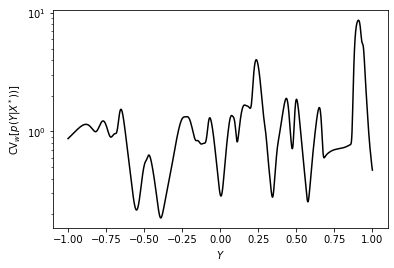

In [58]:
plt.figure(figsize=(6, 4))
plt.plot(ys, ens.mean(axis=0), 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$\mathbb{E}_w[p(Y|X^*))]$')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ys, ens.mean(axis=0), 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$\mathbb{E}_w[p(Y|X^*))]$')
plt.yscale('log')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ys, ens.std(axis=0) / ens.mean(axis=0), 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$\mathrm{CV}_w[p(Y|X^*))]$')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(ys, ens.std(axis=0) / ens.mean(axis=0), 'k')
plt.xlabel(r'$Y$'); plt.ylabel(r'$\mathrm{CV}_w[p(Y|X^*))]$')
plt.yscale('log')
plt.show()